## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


sc21kj

Your full name:

Kalyan Jothimurugan

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [13]:
import cv2
import math
import os
import csv

import numpy as np
from tqdm import tqdm

import torch
import torchvision


import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset
from torch import nn, optim
from torch.optim import lr_scheduler

from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms


from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
from sklearn.metrics import confusion_matrix
import seaborn as sns

root="./data"

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [43]:
def notify():
    os.system("printf '\7'")

## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [15]:
class TinyImageNet(Dataset):
    def __init__(self, result_directory, transform):
        self.result_directory = result_directory
        self.transform = transform
        every_imgs = os.listdir(result_directory)
        self.each_images = natsorted(every_imgs)

    def __len__(self):
        return len(self.each_images)
    
    def __getitem__(self, xyz):
        location = os.path.join(self.result_directory, self.each_images[xyz])
        image = Image.open(location).convert("RGB")
        tensorimage = self.transform(image)
        return self.each_images[xyz] ,torch.unsqueeze(tensorimage, 0)
transform = transforms.Compose(
    [transforms.ToTensor(),  #numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], #(x-mean)/std
                        [0.5,0.5,0.5])])

# Loading datasets
dataset = ImageFolder(root+'/train_set/train_set',transform=transform)
classes = dataset.classes
print((dataset.classes))
training_size = int(0.7 * len(dataset))
validation_size = len(dataset) - training_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
training_loader = torch.utils.data.DataLoader(training_dataset,batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=15, shuffle=True)


    

['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']


In [16]:
class DataLoader(Dataset):
    def __init__(self, main_dir, transform):

        self.main_dir =main_dir
        self.transform = transform

        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return self.total_imgs[idx] ,torch.unsqueeze(tensor_image, 0)

### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [17]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=3,padding=1),   
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16,  kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,out_channels=32,  kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32*8*8,128),     
    nn.ReLU(),
    nn.Linear(128,30)
)

cnn_v1 = net.to(device)

for param in cnn_v1.parameters():
    print(param.shape)

torch.Size([8, 3, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([128, 2048])
torch.Size([128])
torch.Size([30, 128])
torch.Size([30])


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your cnn_v1work given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [6]:
def stats(loader, cnn_v1):
    crct = 0
    total = 0
    runningloss = 0
    n = 0   
    with torch.no_grad():
        for data in loader:
            image_s, label_s = data
            images, labels = image_s.to(device), label_s.to(device)
            out_puts = cnn_v1(images)      
            runningloss += lossfunction(out_puts, labels)
            n += 1
            _, predicted = torch.max(out_puts.data, 1)
            total += labels.size(0)   
            crct += (predicted == labels).sum().item()  
            
    return runningloss/n, crct/total 


In [10]:
%%time
nepochs = 200
resultspath_singlebatch = root+'/resultsnew/cnn_singlebatch.pt'
statsrec = np.zeros((4,nepochs))

lossfunction = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_v1.parameters(), lr=0.001, momentum=0.9)
#inputs, lab = next(iter(training_loader))

iteration = iter(training_loader)
images_s, labels_s = next(iteration)
inputs, labels = images_s.to(device), labels_s.to(device)


for epoch in tqdm(range(nepochs)):  # loop over the dataset multiple times

    crct = 0            # number of examples predicted correctly (for accuracy)  
    total = 0           # number of examples    
    runningloss = 0.0   # accumulated loss (for mean loss)   
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    out_puts = cnn_v1(inputs)
    loss = lossfunction(out_puts, labels)
    loss.backward()
    optimizer.step()
    
    runningloss = loss.item()
    
    #accuracy
    _, predicted = torch.max(out_puts.data, 1)
    total += labels.size(0)    
    crct += (predicted == labels).sum().item()  
    #for record
    ltrn = runningloss
    atrn = crct/total 
    ltst, atst = stats(validation_loader, cnn_v1)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")


torch.save({"state_dict": cnn_v1.state_dict(), "stats": statsrec}, resultspath_singlebatch)

  0%|▏                                          | 1/200 [00:02<09:21,  2.82s/it]

epoch: 0 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  1%|▍                                          | 2/200 [00:05<08:19,  2.52s/it]

epoch: 1 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  2%|▋                                          | 3/200 [00:07<07:57,  2.43s/it]

epoch: 2 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  2%|▊                                          | 4/200 [00:09<07:46,  2.38s/it]

epoch: 3 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  2%|█                                          | 5/200 [00:12<07:39,  2.36s/it]

epoch: 4 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  3%|█▎                                         | 6/200 [00:14<07:33,  2.34s/it]

epoch: 5 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  4%|█▌                                         | 7/200 [00:16<07:29,  2.33s/it]

epoch: 6 training loss:  3.398 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  4%|█▋                                         | 8/200 [00:18<07:26,  2.32s/it]

epoch: 7 training loss:  3.397 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  4%|█▉                                         | 9/200 [00:21<07:23,  2.32s/it]

epoch: 8 training loss:  3.397 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  5%|██                                        | 10/200 [00:23<07:20,  2.32s/it]

epoch: 9 training loss:  3.397 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  6%|██▎                                       | 11/200 [00:25<07:17,  2.32s/it]

epoch: 10 training loss:  3.397 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  6%|██▌                                       | 12/200 [00:28<07:15,  2.31s/it]

epoch: 11 training loss:  3.396 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  6%|██▋                                       | 13/200 [00:30<07:12,  2.31s/it]

epoch: 12 training loss:  3.396 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  7%|██▉                                       | 14/200 [00:32<07:10,  2.31s/it]

epoch: 13 training loss:  3.396 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  8%|███▏                                      | 15/200 [00:35<07:08,  2.31s/it]

epoch: 14 training loss:  3.395 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  8%|███▎                                      | 16/200 [00:37<07:05,  2.31s/it]

epoch: 15 training loss:  3.395 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  8%|███▌                                      | 17/200 [00:39<07:03,  2.31s/it]

epoch: 16 training loss:  3.395 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


  9%|███▊                                      | 18/200 [00:42<07:00,  2.31s/it]

epoch: 17 training loss:  3.394 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 10%|███▉                                      | 19/200 [00:44<06:59,  2.32s/it]

epoch: 18 training loss:  3.394 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 10%|████▏                                     | 20/200 [00:46<06:56,  2.32s/it]

epoch: 19 training loss:  3.393 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 10%|████▍                                     | 21/200 [00:49<06:54,  2.32s/it]

epoch: 20 training loss:  3.393 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 11%|████▌                                     | 22/200 [00:51<06:52,  2.32s/it]

epoch: 21 training loss:  3.393 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 12%|████▊                                     | 23/200 [00:53<06:50,  2.32s/it]

epoch: 22 training loss:  3.392 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 12%|█████                                     | 24/200 [00:56<06:47,  2.32s/it]

epoch: 23 training loss:  3.392 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 12%|█████▎                                    | 25/200 [00:58<06:46,  2.32s/it]

epoch: 24 training loss:  3.392 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 13%|█████▍                                    | 26/200 [01:00<06:43,  2.32s/it]

epoch: 25 training loss:  3.391 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 14%|█████▋                                    | 27/200 [01:02<06:41,  2.32s/it]

epoch: 26 training loss:  3.391 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 14%|█████▉                                    | 28/200 [01:05<06:38,  2.32s/it]

epoch: 27 training loss:  3.390 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 14%|██████                                    | 29/200 [01:07<06:36,  2.32s/it]

epoch: 28 training loss:  3.390 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 15%|██████▎                                   | 30/200 [01:09<06:34,  2.32s/it]

epoch: 29 training loss:  3.390 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 16%|██████▌                                   | 31/200 [01:12<06:32,  2.32s/it]

epoch: 30 training loss:  3.389 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 16%|██████▋                                   | 32/200 [01:14<06:29,  2.32s/it]

epoch: 31 training loss:  3.389 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 16%|██████▉                                   | 33/200 [01:16<06:28,  2.33s/it]

epoch: 32 training loss:  3.388 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 17%|███████▏                                  | 34/200 [01:19<06:25,  2.32s/it]

epoch: 33 training loss:  3.388 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 18%|███████▎                                  | 35/200 [01:21<06:22,  2.32s/it]

epoch: 34 training loss:  3.387 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 18%|███████▌                                  | 36/200 [01:23<06:20,  2.32s/it]

epoch: 35 training loss:  3.387 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 18%|███████▊                                  | 37/200 [01:26<06:18,  2.32s/it]

epoch: 36 training loss:  3.387 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 19%|███████▉                                  | 38/200 [01:28<06:15,  2.32s/it]

epoch: 37 training loss:  3.386 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 20%|████████▏                                 | 39/200 [01:30<06:13,  2.32s/it]

epoch: 38 training loss:  3.386 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 20%|████████▍                                 | 40/200 [01:33<06:11,  2.32s/it]

epoch: 39 training loss:  3.385 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 20%|████████▌                                 | 41/200 [01:35<06:08,  2.32s/it]

epoch: 40 training loss:  3.385 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 21%|████████▊                                 | 42/200 [01:37<06:06,  2.32s/it]

epoch: 41 training loss:  3.385 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 22%|█████████                                 | 43/200 [01:40<06:03,  2.32s/it]

epoch: 42 training loss:  3.384 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 22%|█████████▏                                | 44/200 [01:42<06:01,  2.32s/it]

epoch: 43 training loss:  3.384 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 22%|█████████▍                                | 45/200 [01:44<05:59,  2.32s/it]

epoch: 44 training loss:  3.383 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 23%|█████████▋                                | 46/200 [01:47<05:57,  2.32s/it]

epoch: 45 training loss:  3.383 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 24%|█████████▊                                | 47/200 [01:49<05:55,  2.32s/it]

epoch: 46 training loss:  3.383 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 24%|██████████                                | 48/200 [01:51<05:52,  2.32s/it]

epoch: 47 training loss:  3.382 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 24%|██████████▎                               | 49/200 [01:54<05:50,  2.32s/it]

epoch: 48 training loss:  3.382 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 25%|██████████▌                               | 50/200 [01:56<05:48,  2.32s/it]

epoch: 49 training loss:  3.381 training accuracy:  4.7%  test loss:  3.402 test accuracy:  3.5%


 26%|██████████▋                               | 51/200 [01:58<05:45,  2.32s/it]

epoch: 50 training loss:  3.381 training accuracy:  6.2%  test loss:  3.402 test accuracy:  3.6%


 26%|██████████▉                               | 52/200 [02:01<05:43,  2.32s/it]

epoch: 51 training loss:  3.380 training accuracy:  6.2%  test loss:  3.402 test accuracy:  3.5%


 26%|███████████▏                              | 53/200 [02:03<05:41,  2.32s/it]

epoch: 52 training loss:  3.380 training accuracy:  7.8%  test loss:  3.402 test accuracy:  3.5%


 27%|███████████▎                              | 54/200 [02:05<05:38,  2.32s/it]

epoch: 53 training loss:  3.380 training accuracy:  7.8%  test loss:  3.402 test accuracy:  3.6%


 28%|███████████▌                              | 55/200 [02:08<05:40,  2.35s/it]

epoch: 54 training loss:  3.379 training accuracy:  9.4%  test loss:  3.402 test accuracy:  3.6%


 28%|███████████▊                              | 56/200 [02:10<05:37,  2.34s/it]

epoch: 55 training loss:  3.379 training accuracy:  9.4%  test loss:  3.402 test accuracy:  3.6%


 28%|███████████▉                              | 57/200 [02:12<05:34,  2.34s/it]

epoch: 56 training loss:  3.378 training accuracy:  10.9%  test loss:  3.402 test accuracy:  3.8%


 29%|████████████▏                             | 58/200 [02:15<05:31,  2.33s/it]

epoch: 57 training loss:  3.378 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.9%


 30%|████████████▍                             | 59/200 [02:17<05:28,  2.33s/it]

epoch: 58 training loss:  3.377 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.9%


 30%|████████████▌                             | 60/200 [02:19<05:26,  2.33s/it]

epoch: 59 training loss:  3.377 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.8%


 30%|████████████▊                             | 61/200 [02:22<05:23,  2.33s/it]

epoch: 60 training loss:  3.377 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.7%


 31%|█████████████                             | 62/200 [02:24<05:21,  2.33s/it]

epoch: 61 training loss:  3.376 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.6%


 32%|█████████████▏                            | 63/200 [02:26<05:18,  2.33s/it]

epoch: 62 training loss:  3.376 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.5%


 32%|█████████████▍                            | 64/200 [02:29<05:16,  2.33s/it]

epoch: 63 training loss:  3.375 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.5%


 32%|█████████████▋                            | 65/200 [02:31<05:14,  2.33s/it]

epoch: 64 training loss:  3.375 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.4%


 33%|█████████████▊                            | 66/200 [02:33<05:11,  2.33s/it]

epoch: 65 training loss:  3.374 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.4%


 34%|██████████████                            | 67/200 [02:35<05:09,  2.33s/it]

epoch: 66 training loss:  3.374 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.4%


 34%|██████████████▎                           | 68/200 [02:38<05:07,  2.33s/it]

epoch: 67 training loss:  3.373 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.3%


 34%|██████████████▍                           | 69/200 [02:40<05:06,  2.34s/it]

epoch: 68 training loss:  3.373 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.1%


 35%|██████████████▋                           | 70/200 [02:43<05:03,  2.34s/it]

epoch: 69 training loss:  3.373 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.1%


 36%|██████████████▉                           | 71/200 [02:45<05:01,  2.34s/it]

epoch: 70 training loss:  3.372 training accuracy:  14.1%  test loss:  3.402 test accuracy:  3.0%


 36%|███████████████                           | 72/200 [02:47<05:02,  2.36s/it]

epoch: 71 training loss:  3.372 training accuracy:  12.5%  test loss:  3.402 test accuracy:  3.0%


 36%|███████████████▎                          | 73/200 [02:50<05:00,  2.37s/it]

epoch: 72 training loss:  3.371 training accuracy:  12.5%  test loss:  3.402 test accuracy:  3.1%


 37%|███████████████▌                          | 74/200 [02:52<04:58,  2.37s/it]

epoch: 73 training loss:  3.371 training accuracy:  12.5%  test loss:  3.402 test accuracy:  3.1%


 38%|███████████████▊                          | 75/200 [02:54<04:55,  2.36s/it]

epoch: 74 training loss:  3.370 training accuracy:  12.5%  test loss:  3.402 test accuracy:  3.1%


 38%|███████████████▉                          | 76/200 [02:57<04:51,  2.35s/it]

epoch: 75 training loss:  3.370 training accuracy:  12.5%  test loss:  3.402 test accuracy:  3.2%


 38%|████████████████▏                         | 77/200 [02:59<04:48,  2.35s/it]

epoch: 76 training loss:  3.369 training accuracy:  12.5%  test loss:  3.402 test accuracy:  3.2%


 39%|████████████████▍                         | 78/200 [03:01<04:47,  2.36s/it]

epoch: 77 training loss:  3.369 training accuracy:  10.9%  test loss:  3.402 test accuracy:  3.2%


 40%|████████████████▌                         | 79/200 [03:04<04:52,  2.41s/it]

epoch: 78 training loss:  3.368 training accuracy:  10.9%  test loss:  3.402 test accuracy:  3.2%


 40%|████████████████▊                         | 80/200 [03:06<04:50,  2.42s/it]

epoch: 79 training loss:  3.368 training accuracy:  10.9%  test loss:  3.402 test accuracy:  3.2%


 40%|█████████████████                         | 81/200 [03:09<04:46,  2.40s/it]

epoch: 80 training loss:  3.367 training accuracy:  10.9%  test loss:  3.402 test accuracy:  3.2%


 41%|█████████████████▏                        | 82/200 [03:11<04:41,  2.38s/it]

epoch: 81 training loss:  3.367 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.2%


 42%|█████████████████▍                        | 83/200 [03:13<04:36,  2.37s/it]

epoch: 82 training loss:  3.366 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 42%|█████████████████▋                        | 84/200 [03:16<04:33,  2.36s/it]

epoch: 83 training loss:  3.366 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 42%|█████████████████▊                        | 85/200 [03:18<04:30,  2.35s/it]

epoch: 84 training loss:  3.365 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 43%|██████████████████                        | 86/200 [03:20<04:27,  2.34s/it]

epoch: 85 training loss:  3.365 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 44%|██████████████████▎                       | 87/200 [03:23<04:24,  2.34s/it]

epoch: 86 training loss:  3.364 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 44%|██████████████████▍                       | 88/200 [03:25<04:22,  2.34s/it]

epoch: 87 training loss:  3.364 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 44%|██████████████████▋                       | 89/200 [03:27<04:19,  2.34s/it]

epoch: 88 training loss:  3.363 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 45%|██████████████████▉                       | 90/200 [03:30<04:16,  2.34s/it]

epoch: 89 training loss:  3.363 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 46%|███████████████████                       | 91/200 [03:32<04:14,  2.34s/it]

epoch: 90 training loss:  3.362 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 46%|███████████████████▎                      | 92/200 [03:34<04:12,  2.33s/it]

epoch: 91 training loss:  3.362 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 46%|███████████████████▌                      | 93/200 [03:37<04:09,  2.33s/it]

epoch: 92 training loss:  3.361 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 47%|███████████████████▋                      | 94/200 [03:39<04:07,  2.33s/it]

epoch: 93 training loss:  3.361 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 48%|███████████████████▉                      | 95/200 [03:41<04:04,  2.33s/it]

epoch: 94 training loss:  3.360 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 48%|████████████████████▏                     | 96/200 [03:44<04:02,  2.33s/it]

epoch: 95 training loss:  3.360 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 48%|████████████████████▎                     | 97/200 [03:46<04:00,  2.33s/it]

epoch: 96 training loss:  3.359 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 49%|████████████████████▌                     | 98/200 [03:48<03:58,  2.34s/it]

epoch: 97 training loss:  3.359 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 50%|████████████████████▊                     | 99/200 [03:51<03:55,  2.33s/it]

epoch: 98 training loss:  3.358 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 50%|████████████████████▌                    | 100/200 [03:53<03:53,  2.34s/it]

epoch: 99 training loss:  3.358 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 50%|████████████████████▋                    | 101/200 [03:55<03:51,  2.34s/it]

epoch: 100 training loss:  3.357 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 51%|████████████████████▉                    | 102/200 [03:58<03:48,  2.33s/it]

epoch: 101 training loss:  3.357 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 52%|█████████████████████                    | 103/200 [04:00<03:46,  2.33s/it]

epoch: 102 training loss:  3.356 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 52%|█████████████████████▎                   | 104/200 [04:02<03:43,  2.33s/it]

epoch: 103 training loss:  3.355 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 52%|█████████████████████▌                   | 105/200 [04:05<03:42,  2.34s/it]

epoch: 104 training loss:  3.355 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 53%|█████████████████████▋                   | 106/200 [04:07<03:39,  2.34s/it]

epoch: 105 training loss:  3.354 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 54%|█████████████████████▉                   | 107/200 [04:09<03:37,  2.34s/it]

epoch: 106 training loss:  3.354 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.3%


 54%|██████████████████████▏                  | 108/200 [04:12<03:35,  2.34s/it]

epoch: 107 training loss:  3.353 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 55%|██████████████████████▎                  | 109/200 [04:14<03:32,  2.34s/it]

epoch: 108 training loss:  3.353 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 55%|██████████████████████▌                  | 110/200 [04:16<03:30,  2.33s/it]

epoch: 109 training loss:  3.352 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 56%|██████████████████████▊                  | 111/200 [04:19<03:27,  2.33s/it]

epoch: 110 training loss:  3.351 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 56%|██████████████████████▉                  | 112/200 [04:21<03:26,  2.34s/it]

epoch: 111 training loss:  3.351 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 56%|███████████████████████▏                 | 113/200 [04:23<03:23,  2.34s/it]

epoch: 112 training loss:  3.350 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 57%|███████████████████████▎                 | 114/200 [04:26<03:21,  2.34s/it]

epoch: 113 training loss:  3.349 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 57%|███████████████████████▌                 | 115/200 [04:28<03:18,  2.34s/it]

epoch: 114 training loss:  3.349 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 58%|███████████████████████▊                 | 116/200 [04:31<03:16,  2.34s/it]

epoch: 115 training loss:  3.348 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 58%|███████████████████████▉                 | 117/200 [04:33<03:14,  2.34s/it]

epoch: 116 training loss:  3.347 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 59%|████████████████████████▏                | 118/200 [04:35<03:11,  2.34s/it]

epoch: 117 training loss:  3.347 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 60%|████████████████████████▍                | 119/200 [04:38<03:09,  2.34s/it]

epoch: 118 training loss:  3.346 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 60%|████████████████████████▌                | 120/200 [04:40<03:06,  2.34s/it]

epoch: 119 training loss:  3.345 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 60%|████████████████████████▊                | 121/200 [04:42<03:04,  2.34s/it]

epoch: 120 training loss:  3.345 training accuracy:  10.9%  test loss:  3.404 test accuracy:  3.3%


 61%|█████████████████████████                | 122/200 [04:45<03:02,  2.34s/it]

epoch: 121 training loss:  3.344 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 62%|█████████████████████████▏               | 123/200 [04:47<02:59,  2.34s/it]

epoch: 122 training loss:  3.343 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 62%|█████████████████████████▍               | 124/200 [04:49<02:57,  2.34s/it]

epoch: 123 training loss:  3.343 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 62%|█████████████████████████▋               | 125/200 [04:52<02:55,  2.34s/it]

epoch: 124 training loss:  3.342 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 63%|█████████████████████████▊               | 126/200 [04:54<02:53,  2.34s/it]

epoch: 125 training loss:  3.341 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 64%|██████████████████████████               | 127/200 [04:56<02:50,  2.34s/it]

epoch: 126 training loss:  3.341 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 64%|██████████████████████████▏              | 128/200 [04:59<02:48,  2.34s/it]

epoch: 127 training loss:  3.340 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 64%|██████████████████████████▍              | 129/200 [05:01<02:45,  2.34s/it]

epoch: 128 training loss:  3.339 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 65%|██████████████████████████▋              | 130/200 [05:03<02:43,  2.34s/it]

epoch: 129 training loss:  3.338 training accuracy:  10.9%  test loss:  3.405 test accuracy:  3.3%


 66%|██████████████████████████▊              | 131/200 [05:06<02:41,  2.34s/it]

epoch: 130 training loss:  3.338 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 66%|███████████████████████████              | 132/200 [05:08<02:39,  2.34s/it]

epoch: 131 training loss:  3.337 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 66%|███████████████████████████▎             | 133/200 [05:10<02:36,  2.34s/it]

epoch: 132 training loss:  3.336 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 67%|███████████████████████████▍             | 134/200 [05:13<02:34,  2.34s/it]

epoch: 133 training loss:  3.335 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 68%|███████████████████████████▋             | 135/200 [05:15<02:31,  2.34s/it]

epoch: 134 training loss:  3.334 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 68%|███████████████████████████▉             | 136/200 [05:17<02:29,  2.34s/it]

epoch: 135 training loss:  3.334 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 68%|████████████████████████████             | 137/200 [05:20<02:28,  2.36s/it]

epoch: 136 training loss:  3.333 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 69%|████████████████████████████▎            | 138/200 [05:22<02:26,  2.36s/it]

epoch: 137 training loss:  3.332 training accuracy:  10.9%  test loss:  3.406 test accuracy:  3.3%


 70%|████████████████████████████▍            | 139/200 [05:24<02:23,  2.35s/it]

epoch: 138 training loss:  3.331 training accuracy:  10.9%  test loss:  3.407 test accuracy:  3.3%


 70%|████████████████████████████▋            | 140/200 [05:27<02:20,  2.34s/it]

epoch: 139 training loss:  3.330 training accuracy:  10.9%  test loss:  3.407 test accuracy:  3.3%


 70%|████████████████████████████▉            | 141/200 [05:29<02:18,  2.34s/it]

epoch: 140 training loss:  3.329 training accuracy:  10.9%  test loss:  3.407 test accuracy:  3.3%


 71%|█████████████████████████████            | 142/200 [05:31<02:15,  2.34s/it]

epoch: 141 training loss:  3.328 training accuracy:  10.9%  test loss:  3.407 test accuracy:  3.3%


 72%|█████████████████████████████▎           | 143/200 [05:34<02:13,  2.34s/it]

epoch: 142 training loss:  3.327 training accuracy:  10.9%  test loss:  3.407 test accuracy:  3.3%


 72%|█████████████████████████████▌           | 144/200 [05:36<02:10,  2.34s/it]

epoch: 143 training loss:  3.327 training accuracy:  10.9%  test loss:  3.408 test accuracy:  3.3%


 72%|█████████████████████████████▋           | 145/200 [05:38<02:08,  2.34s/it]

epoch: 144 training loss:  3.326 training accuracy:  10.9%  test loss:  3.408 test accuracy:  3.3%


 73%|█████████████████████████████▉           | 146/200 [05:41<02:06,  2.34s/it]

epoch: 145 training loss:  3.325 training accuracy:  10.9%  test loss:  3.408 test accuracy:  3.3%


 74%|██████████████████████████████▏          | 147/200 [05:43<02:04,  2.34s/it]

epoch: 146 training loss:  3.324 training accuracy:  10.9%  test loss:  3.408 test accuracy:  3.3%


 74%|██████████████████████████████▎          | 148/200 [05:45<02:01,  2.34s/it]

epoch: 147 training loss:  3.323 training accuracy:  10.9%  test loss:  3.408 test accuracy:  3.3%


 74%|██████████████████████████████▌          | 149/200 [05:48<02:01,  2.38s/it]

epoch: 148 training loss:  3.322 training accuracy:  10.9%  test loss:  3.409 test accuracy:  3.3%


 75%|██████████████████████████████▊          | 150/200 [05:50<01:59,  2.39s/it]

epoch: 149 training loss:  3.321 training accuracy:  10.9%  test loss:  3.409 test accuracy:  3.3%


 76%|██████████████████████████████▉          | 151/200 [05:53<01:57,  2.39s/it]

epoch: 150 training loss:  3.320 training accuracy:  10.9%  test loss:  3.409 test accuracy:  3.3%


 76%|███████████████████████████████▏         | 152/200 [05:55<01:54,  2.38s/it]

epoch: 151 training loss:  3.319 training accuracy:  10.9%  test loss:  3.409 test accuracy:  3.3%


 76%|███████████████████████████████▎         | 153/200 [05:57<01:51,  2.37s/it]

epoch: 152 training loss:  3.318 training accuracy:  10.9%  test loss:  3.410 test accuracy:  3.3%


 77%|███████████████████████████████▌         | 154/200 [06:00<01:48,  2.36s/it]

epoch: 153 training loss:  3.317 training accuracy:  10.9%  test loss:  3.410 test accuracy:  3.3%


 78%|███████████████████████████████▊         | 155/200 [06:02<01:45,  2.35s/it]

epoch: 154 training loss:  3.315 training accuracy:  10.9%  test loss:  3.410 test accuracy:  3.3%


 78%|███████████████████████████████▉         | 156/200 [06:04<01:43,  2.35s/it]

epoch: 155 training loss:  3.314 training accuracy:  10.9%  test loss:  3.410 test accuracy:  3.3%


 78%|████████████████████████████████▏        | 157/200 [06:07<01:40,  2.34s/it]

epoch: 156 training loss:  3.313 training accuracy:  10.9%  test loss:  3.411 test accuracy:  3.3%


 79%|████████████████████████████████▍        | 158/200 [06:09<01:38,  2.34s/it]

epoch: 157 training loss:  3.312 training accuracy:  10.9%  test loss:  3.411 test accuracy:  3.3%


 80%|████████████████████████████████▌        | 159/200 [06:11<01:35,  2.34s/it]

epoch: 158 training loss:  3.311 training accuracy:  10.9%  test loss:  3.411 test accuracy:  3.3%


 80%|████████████████████████████████▊        | 160/200 [06:14<01:33,  2.34s/it]

epoch: 159 training loss:  3.310 training accuracy:  10.9%  test loss:  3.412 test accuracy:  3.3%


 80%|█████████████████████████████████        | 161/200 [06:16<01:31,  2.34s/it]

epoch: 160 training loss:  3.309 training accuracy:  10.9%  test loss:  3.412 test accuracy:  3.3%


 81%|█████████████████████████████████▏       | 162/200 [06:18<01:29,  2.34s/it]

epoch: 161 training loss:  3.307 training accuracy:  10.9%  test loss:  3.412 test accuracy:  3.3%


 82%|█████████████████████████████████▍       | 163/200 [06:21<01:26,  2.34s/it]

epoch: 162 training loss:  3.306 training accuracy:  10.9%  test loss:  3.413 test accuracy:  3.3%


 82%|█████████████████████████████████▌       | 164/200 [06:23<01:24,  2.36s/it]

epoch: 163 training loss:  3.305 training accuracy:  10.9%  test loss:  3.413 test accuracy:  3.3%


 82%|█████████████████████████████████▊       | 165/200 [06:25<01:22,  2.36s/it]

epoch: 164 training loss:  3.304 training accuracy:  10.9%  test loss:  3.414 test accuracy:  3.3%


 83%|██████████████████████████████████       | 166/200 [06:28<01:19,  2.35s/it]

epoch: 165 training loss:  3.303 training accuracy:  10.9%  test loss:  3.414 test accuracy:  3.3%


 84%|██████████████████████████████████▏      | 167/200 [06:30<01:17,  2.34s/it]

epoch: 166 training loss:  3.301 training accuracy:  10.9%  test loss:  3.414 test accuracy:  3.3%


 84%|██████████████████████████████████▍      | 168/200 [06:32<01:14,  2.34s/it]

epoch: 167 training loss:  3.300 training accuracy:  10.9%  test loss:  3.415 test accuracy:  3.3%


 84%|██████████████████████████████████▋      | 169/200 [06:35<01:12,  2.34s/it]

epoch: 168 training loss:  3.299 training accuracy:  10.9%  test loss:  3.415 test accuracy:  3.3%


 85%|██████████████████████████████████▊      | 170/200 [06:37<01:10,  2.34s/it]

epoch: 169 training loss:  3.297 training accuracy:  10.9%  test loss:  3.416 test accuracy:  3.3%


 86%|███████████████████████████████████      | 171/200 [06:40<01:08,  2.37s/it]

epoch: 170 training loss:  3.296 training accuracy:  10.9%  test loss:  3.416 test accuracy:  3.3%


 86%|███████████████████████████████████▎     | 172/200 [06:42<01:06,  2.36s/it]

epoch: 171 training loss:  3.295 training accuracy:  10.9%  test loss:  3.417 test accuracy:  3.3%


 86%|███████████████████████████████████▍     | 173/200 [06:44<01:03,  2.36s/it]

epoch: 172 training loss:  3.293 training accuracy:  10.9%  test loss:  3.417 test accuracy:  3.3%


 87%|███████████████████████████████████▋     | 174/200 [06:47<01:01,  2.36s/it]

epoch: 173 training loss:  3.292 training accuracy:  10.9%  test loss:  3.418 test accuracy:  3.3%


 88%|███████████████████████████████████▉     | 175/200 [06:49<00:58,  2.36s/it]

epoch: 174 training loss:  3.291 training accuracy:  10.9%  test loss:  3.419 test accuracy:  3.3%


 88%|████████████████████████████████████     | 176/200 [06:51<00:56,  2.36s/it]

epoch: 175 training loss:  3.289 training accuracy:  10.9%  test loss:  3.419 test accuracy:  3.3%


 88%|████████████████████████████████████▎    | 177/200 [06:54<00:54,  2.35s/it]

epoch: 176 training loss:  3.288 training accuracy:  10.9%  test loss:  3.420 test accuracy:  3.3%


 89%|████████████████████████████████████▍    | 178/200 [06:56<00:51,  2.35s/it]

epoch: 177 training loss:  3.286 training accuracy:  10.9%  test loss:  3.421 test accuracy:  3.3%


 90%|████████████████████████████████████▋    | 179/200 [06:58<00:49,  2.35s/it]

epoch: 178 training loss:  3.285 training accuracy:  10.9%  test loss:  3.421 test accuracy:  3.3%


 90%|████████████████████████████████████▉    | 180/200 [07:01<00:46,  2.35s/it]

epoch: 179 training loss:  3.283 training accuracy:  10.9%  test loss:  3.422 test accuracy:  3.3%


 90%|█████████████████████████████████████    | 181/200 [07:03<00:44,  2.35s/it]

epoch: 180 training loss:  3.282 training accuracy:  10.9%  test loss:  3.423 test accuracy:  3.3%


 91%|█████████████████████████████████████▎   | 182/200 [07:05<00:42,  2.35s/it]

epoch: 181 training loss:  3.280 training accuracy:  10.9%  test loss:  3.423 test accuracy:  3.3%


 92%|█████████████████████████████████████▌   | 183/200 [07:08<00:40,  2.35s/it]

epoch: 182 training loss:  3.279 training accuracy:  10.9%  test loss:  3.424 test accuracy:  3.3%


 92%|█████████████████████████████████████▋   | 184/200 [07:10<00:37,  2.35s/it]

epoch: 183 training loss:  3.277 training accuracy:  10.9%  test loss:  3.425 test accuracy:  3.3%


 92%|█████████████████████████████████████▉   | 185/200 [07:13<00:35,  2.35s/it]

epoch: 184 training loss:  3.275 training accuracy:  10.9%  test loss:  3.426 test accuracy:  3.3%


 93%|██████████████████████████████████████▏  | 186/200 [07:15<00:32,  2.34s/it]

epoch: 185 training loss:  3.274 training accuracy:  10.9%  test loss:  3.427 test accuracy:  3.3%


 94%|██████████████████████████████████████▎  | 187/200 [07:17<00:30,  2.34s/it]

epoch: 186 training loss:  3.272 training accuracy:  10.9%  test loss:  3.428 test accuracy:  3.3%


 94%|██████████████████████████████████████▌  | 188/200 [07:20<00:28,  2.34s/it]

epoch: 187 training loss:  3.271 training accuracy:  10.9%  test loss:  3.429 test accuracy:  3.3%


 94%|██████████████████████████████████████▋  | 189/200 [07:22<00:25,  2.34s/it]

epoch: 188 training loss:  3.269 training accuracy:  10.9%  test loss:  3.430 test accuracy:  3.3%


 95%|██████████████████████████████████████▉  | 190/200 [07:24<00:23,  2.34s/it]

epoch: 189 training loss:  3.267 training accuracy:  10.9%  test loss:  3.431 test accuracy:  3.3%


 96%|███████████████████████████████████████▏ | 191/200 [07:27<00:21,  2.34s/it]

epoch: 190 training loss:  3.266 training accuracy:  10.9%  test loss:  3.432 test accuracy:  3.3%


 96%|███████████████████████████████████████▎ | 192/200 [07:29<00:18,  2.34s/it]

epoch: 191 training loss:  3.264 training accuracy:  10.9%  test loss:  3.433 test accuracy:  3.3%


 96%|███████████████████████████████████████▌ | 193/200 [07:31<00:16,  2.34s/it]

epoch: 192 training loss:  3.262 training accuracy:  10.9%  test loss:  3.434 test accuracy:  3.3%


 97%|███████████████████████████████████████▊ | 194/200 [07:34<00:14,  2.34s/it]

epoch: 193 training loss:  3.261 training accuracy:  10.9%  test loss:  3.436 test accuracy:  3.3%


 98%|███████████████████████████████████████▉ | 195/200 [07:36<00:11,  2.34s/it]

epoch: 194 training loss:  3.259 training accuracy:  10.9%  test loss:  3.437 test accuracy:  3.3%


 98%|████████████████████████████████████████▏| 196/200 [07:38<00:09,  2.35s/it]

epoch: 195 training loss:  3.257 training accuracy:  10.9%  test loss:  3.438 test accuracy:  3.3%


 98%|████████████████████████████████████████▍| 197/200 [07:41<00:07,  2.36s/it]

epoch: 196 training loss:  3.255 training accuracy:  10.9%  test loss:  3.439 test accuracy:  3.3%


 99%|████████████████████████████████████████▌| 198/200 [07:43<00:04,  2.38s/it]

epoch: 197 training loss:  3.254 training accuracy:  10.9%  test loss:  3.441 test accuracy:  3.3%


100%|████████████████████████████████████████▊| 199/200 [07:46<00:02,  2.40s/it]

epoch: 198 training loss:  3.252 training accuracy:  10.9%  test loss:  3.442 test accuracy:  3.3%


100%|█████████████████████████████████████████| 200/200 [07:48<00:00,  2.34s/it]

epoch: 199 training loss:  3.250 training accuracy:  10.9%  test loss:  3.444 test accuracy:  3.3%
CPU times: user 10min 19s, sys: 19.9 s, total: 10min 39s
Wall time: 7min 48s


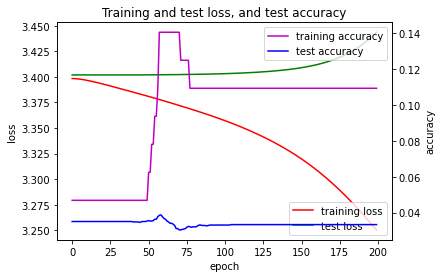

In [20]:
resultspath_singlebatch = root+'/resultsnew/cnn_singlebatch.pt'
data = torch.load(resultspath_singlebatch)
statsrec = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod.svg")
plt.show()

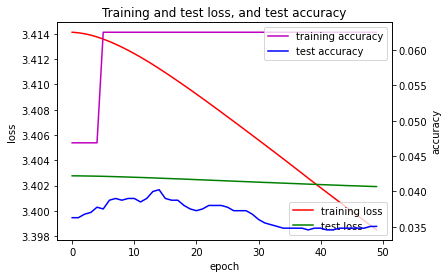

In [9]:
resultspath_singlebatch = root+'/resultsnew/cnn_singlebatch.pt'
data = torch.load(resultspath_singlebatch)
statsrec = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod.svg")
plt.show()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [22]:
%%time
# TO COMPLETE
#nepochs = 300
nepochs = 200
epochs_stop = 10
improve = 0

earlystop=False

resultspath_fulldataset = root+'/resultsnew/cnn_fulldataset.pt'
statsrec = np.zeros((4,nepochs))
lossfunction = nn.CrossEntropyLoss()

optimizer = optim.SGD(cnn_v1.parameters(), lr=0.001, momentum=0.9)
minimumvalloss=np.Inf

for epoch in range(nepochs):  
    crct = 0         
    total = 0            
    runningloss = 0.0   
    n = 0                
    for data in tqdm(training_loader):
        image_s, label_s = data
        images, labels = image_s.to(device), label_s.to(device)
        
        optimizer.zero_grad()
        out_puts = cnn_v1(images)
        
        loss = lossfunction(out_puts, labels)
        loss.backward()
        optimizer.step()
        
        
        runningloss += loss.item()
        n += 1
        
        
        _, predicted = torch.max(out_puts.data, 1)
        total += labels.size(0)   
        crct += (predicted == labels).sum().item() 
        
        
    ltrn = runningloss/n
    atrn = crct/total 
    ltst, atst = stats(validation_loader, cnn_v1)
    if ltst<minimumvalloss:
        epochs_no_improve = 0
        minimumvalloss = ltst
    else:
        epochs_no_improve+=1
        
    if epoch > 5 and epochs_no_improve == epochs_stop:
        print('Early stopping!' )
        earlystop = True
        break
    statsrec[:,epoch] = (ltrn,atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

torch.save({"state_dict": cnn_v1.state_dict(), "stats": statsrec}, resultspath_fulldataset)



100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.88it/s]


epoch: 0 training loss:  3.400 training accuracy:  3.7%  test loss:  3.399 test accuracy:  3.8%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.98it/s]


epoch: 1 training loss:  3.398 training accuracy:  4.2%  test loss:  3.397 test accuracy:  3.8%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.83it/s]


epoch: 2 training loss:  3.395 training accuracy:  3.7%  test loss:  3.393 test accuracy:  4.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.78it/s]


epoch: 3 training loss:  3.389 training accuracy:  4.8%  test loss:  3.385 test accuracy:  6.1%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.71it/s]


epoch: 4 training loss:  3.376 training accuracy:  6.2%  test loss:  3.366 test accuracy:  7.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.91it/s]


epoch: 5 training loss:  3.340 training accuracy:  7.9%  test loss:  3.306 test accuracy:  9.7%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.96it/s]


epoch: 6 training loss:  3.245 training accuracy:  10.2%  test loss:  3.184 test accuracy:  12.4%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.91it/s]


epoch: 7 training loss:  3.122 training accuracy:  12.9%  test loss:  3.067 test accuracy:  13.5%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.85it/s]


epoch: 8 training loss:  3.012 training accuracy:  15.0%  test loss:  3.004 test accuracy:  14.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.91it/s]


epoch: 9 training loss:  2.949 training accuracy:  16.3%  test loss:  2.945 test accuracy:  15.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.86it/s]


epoch: 10 training loss:  2.894 training accuracy:  17.8%  test loss:  2.927 test accuracy:  16.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.91it/s]


epoch: 11 training loss:  2.839 training accuracy:  19.3%  test loss:  2.892 test accuracy:  17.5%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.82it/s]


epoch: 12 training loss:  2.801 training accuracy:  20.4%  test loss:  2.862 test accuracy:  18.4%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.92it/s]


epoch: 13 training loss:  2.761 training accuracy:  21.5%  test loss:  2.835 test accuracy:  19.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.85it/s]


epoch: 14 training loss:  2.723 training accuracy:  22.5%  test loss:  2.793 test accuracy:  20.6%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.89it/s]


epoch: 15 training loss:  2.691 training accuracy:  23.1%  test loss:  2.812 test accuracy:  20.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.85it/s]


epoch: 16 training loss:  2.638 training accuracy:  24.6%  test loss:  2.741 test accuracy:  22.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.88it/s]


epoch: 17 training loss:  2.602 training accuracy:  25.9%  test loss:  2.709 test accuracy:  23.1%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.88it/s]


epoch: 18 training loss:  2.553 training accuracy:  27.5%  test loss:  2.701 test accuracy:  23.9%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.88it/s]


epoch: 19 training loss:  2.515 training accuracy:  28.5%  test loss:  2.624 test accuracy:  25.5%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.87it/s]


epoch: 20 training loss:  2.463 training accuracy:  29.4%  test loss:  2.613 test accuracy:  24.9%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.81it/s]


epoch: 21 training loss:  2.421 training accuracy:  30.6%  test loss:  2.556 test accuracy:  27.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.87it/s]


epoch: 22 training loss:  2.378 training accuracy:  32.1%  test loss:  2.540 test accuracy:  28.0%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.84it/s]


epoch: 23 training loss:  2.330 training accuracy:  32.9%  test loss:  2.501 test accuracy:  28.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.87it/s]


epoch: 24 training loss:  2.290 training accuracy:  34.4%  test loss:  2.494 test accuracy:  28.4%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.84it/s]


epoch: 25 training loss:  2.233 training accuracy:  35.6%  test loss:  2.480 test accuracy:  28.6%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.91it/s]


epoch: 26 training loss:  2.184 training accuracy:  37.0%  test loss:  2.419 test accuracy:  30.0%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.88it/s]


epoch: 27 training loss:  2.140 training accuracy:  38.2%  test loss:  2.379 test accuracy:  31.2%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.75it/s]


epoch: 28 training loss:  2.092 training accuracy:  39.5%  test loss:  2.382 test accuracy:  31.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.85it/s]


epoch: 29 training loss:  2.039 training accuracy:  41.2%  test loss:  2.421 test accuracy:  31.1%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.68it/s]


epoch: 30 training loss:  1.992 training accuracy:  41.7%  test loss:  2.361 test accuracy:  31.8%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.83it/s]


epoch: 31 training loss:  1.941 training accuracy:  43.7%  test loss:  2.364 test accuracy:  32.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.86it/s]


epoch: 32 training loss:  1.900 training accuracy:  45.3%  test loss:  2.276 test accuracy:  34.5%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.81it/s]


epoch: 33 training loss:  1.852 training accuracy:  46.0%  test loss:  2.297 test accuracy:  34.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.87it/s]


epoch: 34 training loss:  1.798 training accuracy:  47.7%  test loss:  2.294 test accuracy:  35.1%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.82it/s]


epoch: 35 training loss:  1.756 training accuracy:  49.6%  test loss:  2.285 test accuracy:  34.7%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.81it/s]


epoch: 36 training loss:  1.707 training accuracy:  50.2%  test loss:  2.292 test accuracy:  35.5%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.78it/s]


epoch: 37 training loss:  1.668 training accuracy:  51.2%  test loss:  2.306 test accuracy:  34.7%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.87it/s]


epoch: 38 training loss:  1.615 training accuracy:  53.1%  test loss:  2.375 test accuracy:  34.3%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.78it/s]


epoch: 39 training loss:  1.574 training accuracy:  53.8%  test loss:  2.329 test accuracy:  35.0%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.87it/s]


epoch: 40 training loss:  1.514 training accuracy:  55.6%  test loss:  2.370 test accuracy:  34.4%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.78it/s]


epoch: 41 training loss:  1.475 training accuracy:  56.5%  test loss:  2.441 test accuracy:  33.8%


100%|█████████████████████████████████████████| 148/148 [00:13<00:00, 10.86it/s]


Early stopping!
CPU times: user 13min 28s, sys: 21 s, total: 13min 49s
Wall time: 11min 47s


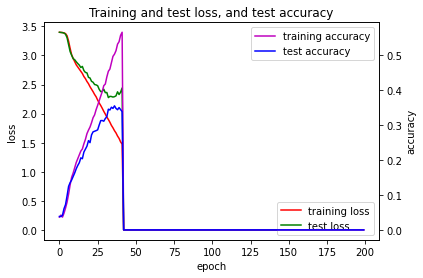

In [23]:
resultspath_fulldataset = root+'/resultsnew/cnn_fulldataset.pt'
data = torch.load(resultspath_fulldataset)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod1.svg")
plt.show()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [24]:
transform = transforms.Compose([                        
   transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

dataset = ImageFolder(root+'/train_set/train_set',transform=transform)
print(dataset)
print(len(dataset.classes))
training_loader= int(0.80 * len(dataset))
validation_size = len(dataset) - training_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
training_loader = torch.utils.data.DataLoader(training_dataset,batch_size=64, shuffle=True,num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=64, shuffle=True,num_workers=2)


Dataset ImageFolder
    Number of datapoints: 13500
    Root location: ./data/train_set/train_set
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.05)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
30


In [39]:
# Adding drop out
model_122a = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=50, kernel_size=3,padding=1),  
    nn.ReLU(inplace=True), 
    nn.Conv2d(in_channels=50,out_channels=75,  kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),  
    nn.Conv2d(in_channels=75,out_channels=125,  kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=125,out_channels=256,  kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.25),
    nn.Flatten(),
    nn.Linear(256*8*8,1000), 
    nn.Dropout(p=0.25),  
    nn.Linear(1000,500),
    nn.Dropout(p=0.25),  
    nn.Linear(500,200),
    nn.Dropout(p=0.5),
    nn.Linear(200,30)
)

cnn_v3 = model_122a.to(device)

for param in cnn_v3.parameters():
    print(param.shape)

torch.Size([50, 3, 3, 3])
torch.Size([50])
torch.Size([75, 50, 3, 3])
torch.Size([75])
torch.Size([125, 75, 3, 3])
torch.Size([125])
torch.Size([256, 125, 3, 3])
torch.Size([256])
torch.Size([1000, 16384])
torch.Size([1000])
torch.Size([500, 1000])
torch.Size([500])
torch.Size([200, 500])
torch.Size([200])
torch.Size([30, 200])
torch.Size([30])


In [38]:
model_122b = nn.Sequential (
    nn.Conv2d(3,6,5),
    nn.MaxPool2d(2,2),
    nn.ReLU(),
    nn.Conv2d(6,16,5),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16,32,5),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(32*4*4,128),
    nn.Linear(128, 84),
    nn.Linear(84, 30)
)

cnn_v3 = model_122b.to(device)
for param in cnn_v3.parameters():
    print(param.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([128, 512])
torch.Size([128])
torch.Size([84, 128])
torch.Size([84])
torch.Size([30, 84])
torch.Size([30])


In [35]:

model_122c = nn.Sequential (
    nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(82944,1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512,30)
)

cnn_v3 = model_122c.to(device)
for param in cnn_v3.parameters():
    print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([1024, 82944])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([30, 512])
torch.Size([30])


In [40]:
def stats1(loader, cnn_v3):
    crct = 0
    total = 0
    runningloss = 0
    n = 0    
    with torch.no_grad():
        for data in loader:
            image_s, label_s = data
            images, labels = image_s.to(device), label_s.to(device)
            
            out_puts = cnn_v3(images)      
            runningloss += lossfunction(out_puts, labels)
            n += 1
            _, predicted = torch.max(out_puts.data, 1)
            total += labels.size(0)    
            crct += (predicted == labels).sum().item() 
            
    return runningloss/n, crct/total 

In [46]:
%%time
nepochs = 20

resultspath_finetuned = root+'/resultsnew/cnn_finetuned.pt'
statsrec = np.zeros((4,nepochs))
lossfunction = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(cnn_v3.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)
minimumvalloss=np.Inf
for epoch in (range(nepochs)): 
    crct = 0          
    total = 0            
    runningloss = 0.0   
    n = 0
    for data in tqdm(training_loader):
        image_s, label_s = data
        images, labels = image_s.to(device), label_s.to(device)
        
        optimizer2.zero_grad()
        
        out_puts = cnn_v3(images)
        loss = lossfunction(out_puts, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()
        n += 1
        _, predicted = torch.max(out_puts.data, 1)
        total += labels.size(0)   
        crct += (predicted == labels).sum().item() 
    ltrn = runningloss/n
    atrn = crct/total 
    ltst, atst = stats1(validation_loader, cnn_v3)
    scheduler.step(ltst/len(validation_loader))
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

torch.save({"state_dict": cnn_v3.state_dict(), "stats": statsrec}, resultspath_finetuned)

notify()

100%|█████████████████████████████████████████| 148/148 [10:09<00:00,  4.12s/it]


epoch: 0 training loss:  3.402 training accuracy:  3.4%  test loss:  3.402 test accuracy:  3.2%


100%|█████████████████████████████████████████| 148/148 [10:00<00:00,  4.06s/it]


epoch: 1 training loss:  3.402 training accuracy:  3.3%  test loss:  3.402 test accuracy:  3.3%


100%|█████████████████████████████████████████| 148/148 [10:03<00:00,  4.08s/it]


epoch: 2 training loss:  3.402 training accuracy:  3.6%  test loss:  3.402 test accuracy:  2.9%


100%|█████████████████████████████████████████| 148/148 [10:03<00:00,  4.08s/it]


epoch: 3 training loss:  3.402 training accuracy:  3.7%  test loss:  3.402 test accuracy:  3.1%


100%|█████████████████████████████████████████| 148/148 [10:04<00:00,  4.09s/it]


epoch: 4 training loss:  3.401 training accuracy:  3.6%  test loss:  3.401 test accuracy:  3.3%


100%|█████████████████████████████████████████| 148/148 [10:02<00:00,  4.07s/it]


epoch: 5 training loss:  3.402 training accuracy:  3.5%  test loss:  3.402 test accuracy:  3.0%


100%|█████████████████████████████████████████| 148/148 [10:00<00:00,  4.05s/it]


epoch: 6 training loss:  3.402 training accuracy:  3.5%  test loss:  3.402 test accuracy:  2.9%


100%|█████████████████████████████████████████| 148/148 [10:03<00:00,  4.08s/it]


epoch: 7 training loss:  3.402 training accuracy:  3.2%  test loss:  3.402 test accuracy:  3.2%


100%|█████████████████████████████████████████| 148/148 [10:02<00:00,  4.07s/it]


epoch: 8 training loss:  3.402 training accuracy:  3.8%  test loss:  3.402 test accuracy:  3.2%


100%|█████████████████████████████████████████| 148/148 [09:59<00:00,  4.05s/it]


epoch: 9 training loss:  3.402 training accuracy:  3.8%  test loss:  3.401 test accuracy:  3.3%


100%|█████████████████████████████████████████| 148/148 [09:59<00:00,  4.05s/it]


epoch: 10 training loss:  3.402 training accuracy:  3.4%  test loss:  3.402 test accuracy:  3.1%


100%|█████████████████████████████████████████| 148/148 [10:10<00:00,  4.13s/it]


epoch: 11 training loss:  3.402 training accuracy:  3.5%  test loss:  3.401 test accuracy:  3.4%


100%|█████████████████████████████████████████| 148/148 [09:59<00:00,  4.05s/it]


epoch: 12 training loss:  3.402 training accuracy:  3.6%  test loss:  3.402 test accuracy:  3.4%


100%|█████████████████████████████████████████| 148/148 [10:03<00:00,  4.08s/it]


epoch: 13 training loss:  3.402 training accuracy:  3.3%  test loss:  3.402 test accuracy:  3.0%


100%|█████████████████████████████████████████| 148/148 [10:29<00:00,  4.25s/it]


epoch: 14 training loss:  3.402 training accuracy:  3.7%  test loss:  3.402 test accuracy:  2.8%


100%|█████████████████████████████████████████| 148/148 [10:08<00:00,  4.11s/it]


epoch: 15 training loss:  3.402 training accuracy:  3.8%  test loss:  3.402 test accuracy:  3.0%


100%|█████████████████████████████████████████| 148/148 [10:30<00:00,  4.26s/it]


epoch: 16 training loss:  3.402 training accuracy:  3.8%  test loss:  3.401 test accuracy:  3.5%


100%|█████████████████████████████████████████| 148/148 [10:22<00:00,  4.20s/it]


epoch: 17 training loss:  3.402 training accuracy:  3.9%  test loss:  3.402 test accuracy:  3.5%


100%|█████████████████████████████████████████| 148/148 [10:11<00:00,  4.13s/it]


epoch: 18 training loss:  3.402 training accuracy:  3.9%  test loss:  3.401 test accuracy:  3.6%


100%|█████████████████████████████████████████| 148/148 [10:08<00:00,  4.11s/it]


epoch: 19 training loss:  3.402 training accuracy:  3.8%  test loss:  3.402 test accuracy:  3.3%
CPU times: user 3h 59min 59s, sys: 4min 12s, total: 4h 4min 12s
Wall time: 3h 55min 6s


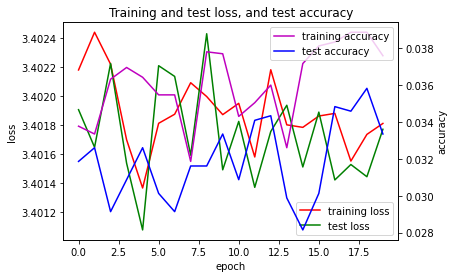

In [47]:
resultspath_finetuned = root+'/resultsnew/cnn_finetuned.pt'
data = torch.load(resultspath_finetuned)
statsrec = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod1.svg")
plt.show()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

In [ ]:
ax = plt.subplot(2,2,1)
data = torch.load(resultspath_singlebatch)
statsrec = data["stats"]
plt.plot(statsrec[1], 'r', label =  'training accuracy', )
plt.plot(statsrec[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Single batch training')
plt.legend(loc='upper right')
plt.show()


ax = plt.subplot(2,2,1)

data = torch.load(resultspath_fulldataset)
statsrec = data["stats"]
plt.plot(statsrec[1], 'r', label =  'training accuracy', )
plt.plot(statsrec[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Whole training dataset training')
plt.legend(loc='upper right')
plt.show()

ax = plt.subplot(2,2,1)

data = torch.load(resultspath_finetuned)
statsrec = data["stats"]
plt.plot(statsrec[1], 'r', label =  'training accuracy', )
plt.plot(statsrec[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Finetuning training')

plt.legend(loc='upper right')
plt.show()


When model is trained for single batch, its accuracy increases exponentially.

While model is trained on whole data set, the model reaches full accuracy in minimal epochs but then falls to zero after wards.

For the finetuning graph , we can see in both the cases, there was a sharp increase together which may lead to overfitting.



### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

data=torch.load(resultspath_finetuned)
cnn_v2.load_state_dict(data["state_dict"])
cnn_v2.eval()
y_pred = []
y_true = []
class_list=[]
for key in dataset.class_to_idx.keys():
    class_list.append(key)
# iterate over test data
for data in training_loader:
    
    input_s, label_s = data
    inputs, labels = input_s.to(device), label_s.to(device)
    output = cnn_v2(inputs) # Feed Network
    # _, predicted = torch.max(outputs.data, 1)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    
   # output = predicted.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    #labels = labels.data.numpy()
    y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_list],
                     columns = [i for i in class_list])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusionmatrix_output.png')

What conclusions can be drawn from the confusion matrices?



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [ ]:
# results = []

# with torch.no_grad():
#     for data in validation_loader:
#         input_s, label_s = data
#         inputs, labels = input_s.to(device), label_s.to(device)

#     outputs = cnn_v2(inputs)
#     results.extend(outputs.argmax(dim=1).type(torch.int32).cpu().numpy())

In [ ]:
# # TO COMPLETE

# results_path_finetune = root+'/resultsnew/cnn_finetuned.pt'
# data=torch.load(results_path_finetune)
# cnn_v2.load_state_dict(data["state_dict"])
# cnn_v2.eval()
# dataset = LoadFromFolder(root+"/test_set/test_set",transform=transform )


# from torch.utils.data import DataLoader
# predicted_list=[]
# for i in range(len(dataset)):
#     image_name, image =dataset.__getitem__(i)
#     outputs=model_122(image)#
#     _, predicted = torch.max(outputs.data, 1)
#     data = [image_name,predicted.numpy()[0] ]  
#     predicted_list.append(data)
#     # write a row to the csv file
 



In [ ]:
torch.__version__


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [81]:
#using alexnet

from csv import writer

dataset1 = DataLoader(root+'/test_set/test_set',transform=transform )
print(len(dataset1))
prediction = []

for data in dataset1:
    labels, inputs = data
    #inputs, labels = input_s.to(device), label_s.to(device)

    outputs = model(inputs)
    #results.extend(outputs.argmax(dim=1).type(torch.int32).cpu().numpy())
    _, predicted1 = torch.max(outputs.data, 1)
    data1 = [labels,predicted1.numpy()[0] ]  
    prediction.append(data1)

    
with open("sc21kj_al.csv", 'a', newline='') as f_object:  
    w_obj = writer(f_object)
    for data1 in prediction:
        w_obj.writerow(data1)
    f_object.close()
    
notify()

1500


In [79]:
from csv import writer

dataset1 = DataLoader(root+'/test_set/test_set',transform=transform )
print(len(dataset1))
prediction = []

with torch.no_grad():
    for data in dataset1:
        labels, inputs = data
        #inputs, labels = input_s.to(device), label_s.to(device)

        outputs = cnn_v2(inputs)
        #results.extend(outputs.argmax(dim=1).type(torch.int32).cpu().numpy())
        _, predicted1 = torch.max(outputs.data, 1)
        data1 = [labels,predicted1.numpy()[0] ]  
        prediction.append(data1)

    
with open("sc21kj.csv", 'a', newline='') as f_object:  
    w_obj = writer(f_object)
    for data1 in prediction:
        w_obj.writerow(data1)
    f_object.close()
    
notify()

1500




## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [54]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /Users/ajithkalyan/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [55]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [56]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [57]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [58]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight.data.clone()
     
    return filters

In [59]:

conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [60]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [61]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



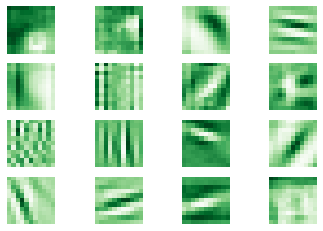

In [62]:

to_show = 16


plt_dim = int(math.sqrt(to_show))


for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="Greens")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [63]:

from PIL import Image
im=Image.open(root+'/man_bike.JPEG').convert("RGB")
print(im)


<PIL.Image.Image image mode=RGB size=500x375 at 0x161B90E80>


Run the code cell below to apply the image transformation expected by the model.

In [64]:

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [65]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
     
    
    model_weights =[]
   
    conv_layers = []
   
    all_layers=[]
    counter = 0 
    maxpool=[]
    model_children = list(model.children())

    for j in range(len(model_children[0])):
        child= model_children[0][j]
        all_layers.append(child)
        if type(child) == nn.MaxPool2d:
            
            counter += 1
 

    print(counter)
    results = [all_layers[0](image)]
  
    for i in range(1, len(all_layers)):
        
        x=all_layers[i](results[-1])
        results.append(x)
        if len(results[i][0][0]) == len(results[i-1][0][0])// 2:
            maxpool.append(x)
       
   
    maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]
    
    return maxpool

In [66]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

3


/var/folders/20/fhjypz_x5yb3__tx_g6cgjk00000gn/T/ipykernel_97916/4082719065.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]


For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [67]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

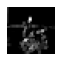

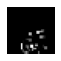

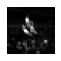

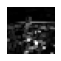

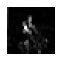

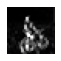

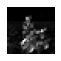

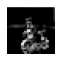

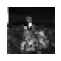

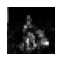

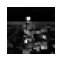

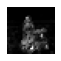

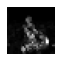

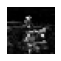

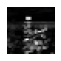

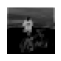

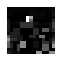

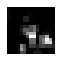

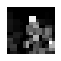

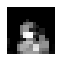

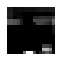

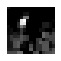

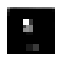

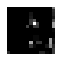

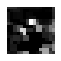

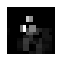

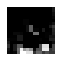

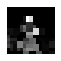

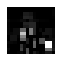

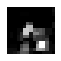

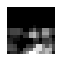

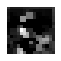

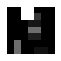

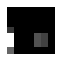

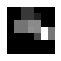

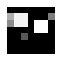

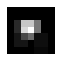

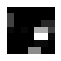

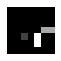

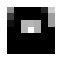

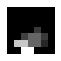

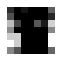

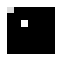

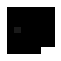

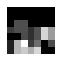

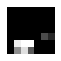

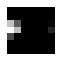

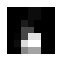

In [68]:
 # limit
n = 16

 
plt_dim = int(math.sqrt(n))


for i in range(3):
    for i, filt in enumerate(feature_maps[i][0].numpy()[:n]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
        plt.show()

 

 




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


--> Filter 0 -> It is classifying and grouping man and block as one element. Able to see the silhoute of the man as part of fore ground. It also detects foreground elements.

--> Filter 4 -> It detects much clearer picture of man's head and his torso.

--> Filter 6 -> Able to identify the wheels of the cycle.

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.



--> At first, the filters detect multiple colors and edges and is able to identify different shapes.

--> At final layers, we can see more clearer image with more complex patterns that is used to identify the element in the image.

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.






--> As depth increases, the image is broken down into simpler blocks.
--> At first, we will be able to see and differentiate between foreground and background scenes, but as the depth increases, it will be reduced and will be able to only see shapes that appears in the image.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [69]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    
    def activations_hook(self, grad):
        
        self.gradients = grad

  
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [70]:
model = alexnet(pretrained=True)

In [71]:

output = model(im.unsqueeze(0))
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [72]:
print(output.shape)
print(pred_cls)
 

torch.Size([1, 1000])
tensor([[671]])


### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [73]:
def generate_heatmap(output, class_id, model, image):
    
    output[:,-1].backward()
    
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
   
    heatmap = np.maximum(heatmap, 0)

   
    heatmap /= torch.max(heatmap)

    return heatmap

In [74]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

torch.Size([7, 7])

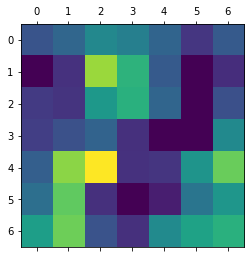

In [75]:
heatmap.shape 
plt.matshow(heatmap.squeeze())
heatmap.shape

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

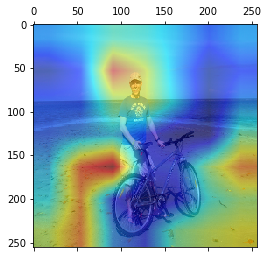

In [76]:

def display_heatmap(heatmap,image):
    (w, h) = (image.shape[0], image.shape[1])
    heatmap = cv2.resize(heatmap.numpy(), (w, h))
    
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + 1e-8
    heatmap_normalized = numer / denom
    heatmap_normalized = (heatmap_normalized * 255).astype("uint8")

    heatmap_normalized = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
    
    heatmap_normalized=heatmap_normalized * 0.4
    
    weighted_image= cv2.addWeighted(heatmap_normalized, 0.7, image, 0.3, 0)
    
    numer = weighted_image - np.min(weighted_image)
    denom = (weighted_image.max() - weighted_image.min()) + 1e-8
    final_image = numer / denom
    final_image = (final_image * 255).astype("uint8")

    return final_image

image = cv2.imread(root+'/man_bike.JPEG')
image=cv2.resize(image,(256,256))
image = np.asarray(image, np.float64)

display=display_heatmap(heatmap,image)
plt.matshow(display[:, :, ::-1])

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

tensor([[345]])


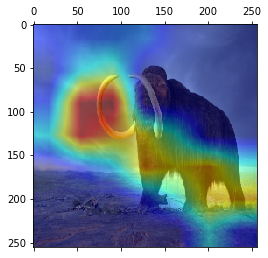

In [77]:


mammoth=Image.open(root+'/mammoth.jpg')


norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

mammoth = data_transform(mammoth)
mod = alexnet(pretrained=True)


output = mod(mammoth.unsqueeze(0))

_, pred_cls = output.max(dim=1, keepdim=True)
print(pred_cls)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100  
 

heatmap = generate_heatmap(output, pred_cls, mod, mammoth.unsqueeze(0))
mammoth=cv2.imread(root+'/mammoth.jpg')

mammoth=cv2.resize(mammoth,(256,256))
mammoth = np.asarray(mammoth, np.float64)
show_result = display_heatmap(heatmap, mammoth)
plt.matshow(show_result[:, :, ::-1])

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

The image that we have used is an mammoth image, but the model considers it as an ox. It may be because it has tusk similar to horns in an ox and also because of the fur.


### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
